In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

In [2]:
well2 = pd.read_csv("./data/well_2.txt", header=None, skiprows=1, sep="  ", usecols=[0,3,6,9,11,14])
well2.rename(columns={0:"DEPTH", 3:"VP", 6:"VS", 9:"DEN", 11:"GR", 14:"NPHI" }, inplace=True)

C:\Users\Dunbar\AppData\Local\Temp\ipykernel_30032\2958785718.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  well2 = pd.read_csv("./data/well_2.txt", header=None, skiprows=1, sep="  ", usecols=[0,3,6,9,11,14])


In [3]:
features = ['VP', 'DEN', 'GR']
target = 'VS'
# define what logs are we going to use
feature_target = ['VP', 'DEN', 'GR', 'VS']

# train columns to use
train_cols = ['DEPTH', 'VP', 'DEN', 'GR', 'VS']

# test columns to use
test_cols = ['DEPTH', 'VP', 'DEN', 'GR']

In [4]:
well2 = well2[train_cols]           # DEPTH, 'VP', 'DEN', 'GR', 'VS'
well_train = well2[feature_target]  #        'VP', 'DEN', 'GR', 'VS'

In [5]:
well2.isnull().sum()

DEPTH    0
VP       0
DEN      0
GR       0
VS       0
dtype: int64

In [6]:
colnames = well_train.columns  # 'VP', 'DEN', 'GR', 'VS'  => same as 'feature_target'
colnames

Index(['VP', 'DEN', 'GR', 'VS'], dtype='object')

In [7]:
# depth_train = well_train.pop('DEPTH')
# well_train['DEPTH'] = depth_train

In [8]:
# normalize using power transform Yeo-Johnson method
scaler = PowerTransformer(method='yeo-johnson')

## ColumnTransformer
ct = ColumnTransformer([('transform', scaler, feature_target)], remainder='passthrough')

In [9]:
## fit and transform
well_train_norm = ct.fit_transform(well_train)

## convert to dataframe
well_train_norm = pd.DataFrame(well_train_norm, columns=colnames)

In [10]:
# make copy of well_train_norm, called well_train_dropped
well_train_drop = well_train_norm.copy()

# # on the well_train_drop, drop WELL and DEPTH column
# well_train_drop = well_train_norm.drop(['DEPTH'], axis=1)

C:\Users\Dunbar\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Number of points before outliers removed                       : 4117
Number of points after outliers removed with Standard Deviation: 4084
Number of points after outliers removed with Isolation Forest  : 2059
Number of points after outliers removed with Min. Covariance   : 3705
Number of points after outliers removed with Outlier Factor    : 2882
Number of points after outliers removed with One-class SVM     : 3704


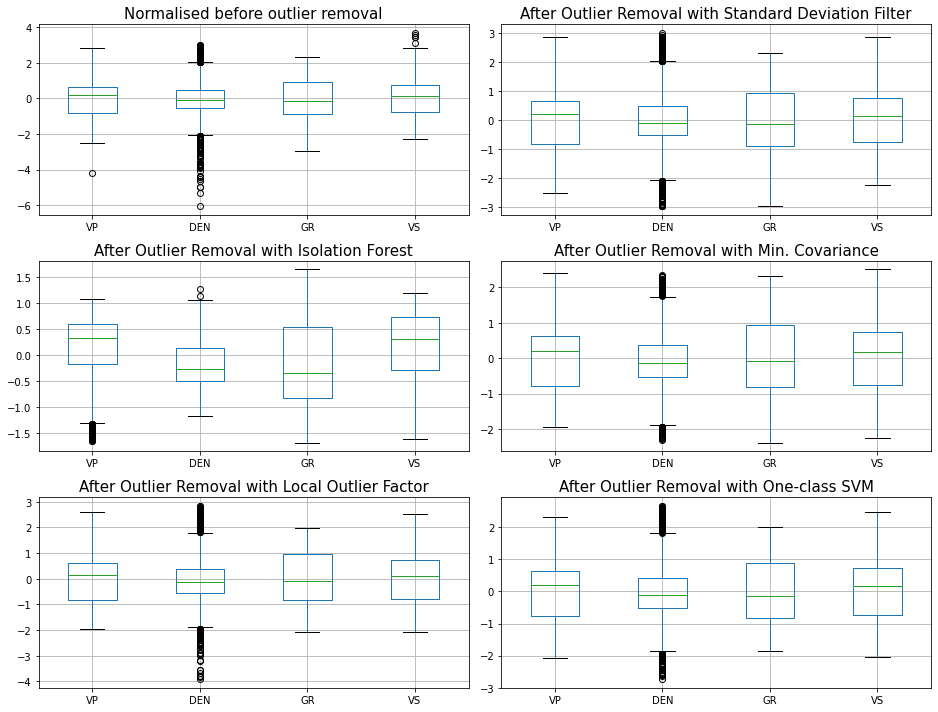

In [11]:
# Method 1: Standard Deviation Method (traditional)
well_train_std = well_train_drop[np.abs(well_train_drop - well_train_drop.mean()) <= (3 * well_train_drop.std())]

## delete all rows that have NaNs
well_train_std = well_train_std.dropna()

# Method 2: Isolation Forest
iso = IsolationForest(contamination=0.5)
yhat = iso.fit_predict(well_train_drop)
mask = yhat != -1
well_train_iso = well_train_norm[mask]

# Method 3: Minimum Covariance Determinant
ee = EllipticEnvelope(contamination=0.1)
yhat = ee.fit_predict(well_train_drop)
mask = yhat != -1
well_train_ee = well_train_norm[mask]

# Method 4: Local Outlier Factor
lof = LocalOutlierFactor(contamination=0.3)
yhat = lof.fit_predict(well_train_drop)
mask = yhat != -1
well_train_lof = well_train_norm[mask]

# Method 5: One-class SVM
svm = OneClassSVM(nu=0.1)
yhat = svm.fit_predict(well_train_drop)
mask = yhat != -1
well_train_svm = well_train_norm[mask]

print('Number of points before outliers removed                       :', len(well_train_norm))
print('Number of points after outliers removed with Standard Deviation:', len(well_train_std))
print('Number of points after outliers removed with Isolation Forest  :', len(well_train_iso))
print('Number of points after outliers removed with Min. Covariance   :', len(well_train_ee))
print('Number of points after outliers removed with Outlier Factor    :', len(well_train_lof))
print('Number of points after outliers removed with One-class SVM     :', len(well_train_svm))

plt.figure(figsize=(13,10))

plt.subplot(3,2,1)
well_train_norm[feature_target].boxplot()
plt.title('Normalised before outlier removal', size=15)

plt.subplot(3,2,2)
well_train_std[feature_target].boxplot()
plt.title('After Outlier Removal with Standard Deviation Filter', size=15)

plt.subplot(3,2,3)
well_train_iso[feature_target].boxplot()
plt.title('After Outlier Removal with Isolation Forest', size=15)

plt.subplot(3,2,4)
well_train_ee[feature_target].boxplot()
plt.title('After Outlier Removal with Min. Covariance', size=15)

plt.subplot(3,2,5)
well_train_lof[feature_target].boxplot()
plt.title('After Outlier Removal with Local Outlier Factor', size=15)

plt.subplot(3,2,6)
well_train_svm[feature_target].boxplot()
plt.title('After Outlier Removal with One-class SVM', size=15)

plt.tight_layout()
plt.show()

In [12]:
X_train = well_train_svm[features].values
y_train = well_train_svm[target].values

In [13]:
# Define the test data 
test = well_train_norm.copy()

# define X_test (feature) and y_test (target)
X_test, y_test = test[features].values, test[target].values

In [14]:
# Create the regressor
model = GradientBoostingRegressor()
# print(model)

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Predict on well 2
y_pred = model.predict(X_test)
print("R-squared of Well 1: {}".format(model.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE of Well 1: {}".format(rmse))

R-squared of Well 1: 0.921768504478367
RMSE of Well 1: 0.27969893729085393


In [15]:
# make the transformer fit to the target
y = well_train[target].values
scaler.fit(y.reshape(-1,1))

# denormalize y_test, y_pred
y_test, y_pred = scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(y_pred.reshape(-1,1))

In [16]:
well2['VS_pred'] = y_pred


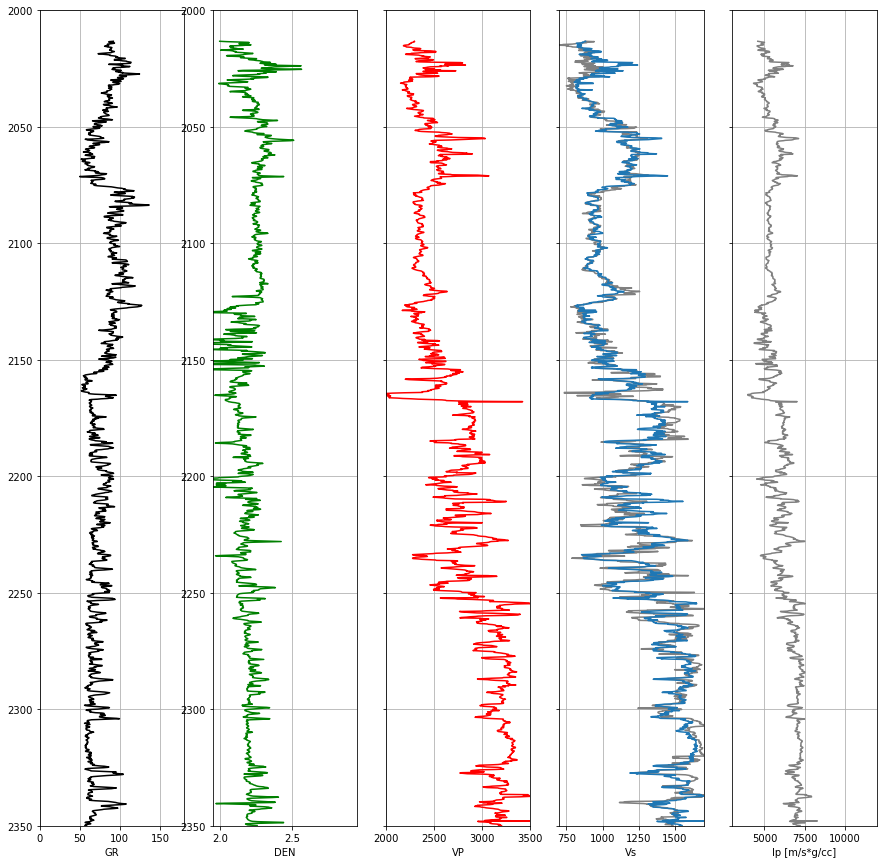

In [17]:
ztop=2000; zbot=2350
ll=well2[(well2.DEPTH>=ztop) & (well2.DEPTH<=zbot)]

#cluster=np.repeat(np.expand_dims(ll['FACIES'].values,1), 100, 1)

f, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))

#ax[0].plot(ll.PHIE, ll.DEPTH, label='PHIE')
#ax[0].plot(ll.VSH, ll.DEPTH, label='VSH')
ax[0].plot(ll.GR, ll.DEPTH, '-k', label='GR')
ax[2].plot(ll.VP*1000, ll.DEPTH, '-r', label='VP')
ax[1].plot(ll.DEN, ll.DEPTH, '-g', label='Density')
ax[4].plot(ll.VP*1000*ll.DEN, ll.DEPTH, '-', color='0.5')
ax[3].plot(ll.VS*1000, ll.DEPTH, '-', color='0.5')
ax[3].plot(ll.VS_pred*1000, ll.DEPTH)


for i in range(len(ax)):
    ax[i].set_ylim(ztop,zbot)
    ax[i].invert_yaxis()
    ax[i].grid()
    ax[i].locator_params(axis='x', nbins=4)
#ax[0].legend(fontsize='small', loc='lower right')

ax[0].set_xlabel("GR"),            ax[0].set_xlim(0,180)
ax[1].set_xlabel("DEN"),           ax[1].set_xlim(1.95, 2.95),     #ax[1].set_yticklabels([])
ax[2].set_xlabel("VP"),            ax[2].set_xlim(2000, 3500), ax[2].set_yticklabels([])
ax[3].set_xlabel("Vs"),            ax[3].set_xlim(700, 1700), ax[3].set_yticklabels([])
ax[4].set_xlabel("Ip [m/s*g/cc]"), ax[4].set_xlim(3000,12000), ax[4].set_yticklabels([]);
